# Исследование для молочного хозяйства 

Проект посвящён разработке модели машинного обучения, которая поможет владельцу молочного хозяйства управлять рисками и принимать объективное решение о покупке коров. С помощью модели нужно отобрать коров для покупки по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

In [1]:
# загружаю все нужные для проекта библиотеки

import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import pandas as pd
import phik
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             mean_absolute_error, mean_squared_error, 
                             precision_recall_curve, precision_score, 
                             r2_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
def load_data(file_name):
    """
    Функция выгружает датафрейм и выводит информацию по нему.

    Parameters:
    file_name (str): путь к CSV-файлу, который надо загрузить

    Returns:
    DataFrame: датафрейм с информацией из CSV-файла
    """
    data = pd.read_csv(file_name, sep=';', decimal=',') # разделила данные в датасете по столбцам и поправила разделитель в дробях
    print(data.head())
    data.info()
    return data


def plot_cat_data(data, title, ax):
    """
    Функция создаёт график bar с использованием seaborn.

    Parameters:
    data (pandas.DataFrame): данные, на которых будут строить графики
    title (str): названия графиков
    ax (matplotlib.axes.Axes): объект оси, на котором нужно построить график


    Returns:
    None
    """
    sns.countplot(x=data, ax=ax)
    ax.set_title(title)
    
def plot_num_data(data, title, ax):
    """
    Функция создаёт график boxplot с использованием seaborn.

    Parameters:
    data (pandas.DataFrame): данные, на которых будут строить графики
    title (str): названия графиков
    ax (matplotlib.axes.Axes): объект оси, на котором нужно построить график


    Returns:
    None
    """
    sns.boxplot(data=data, ax=ax) # ящик с усами
    ax.set_title(title)
    
def hist_num_data(data, title, ax):
    """
    Функция создаёт график hist с использованием seaborn.

    Parameters:
    data (pandas.DataFrame): данные, на которых будут строить графики
    title (str): названия графиков
    ax (matplotlib.axes.Axes): объект оси, на котором нужно построить график


    Returns:
    None
    """
    sns.histplot(data=data, ax=ax) # гистограмма
    ax.set_title(title)
    
def data_for_model(data, drop_col, cat_col, num_col, random_state=42):
    """
    Функция для предварительной обработки данных: кодирования категориальных признаков, масштабирования числовых признаков и разделения на обучающую и тестовую выборки.

    Параметры:
    df (pandas.DataFrame): исходный датафрейм
    drop_cols (list): список столбцов для удаления (целевые переменные)
    cat_cols (list): список категориальных признаков для кодирования
    num_cols (list): список числовых признаков для масштабирования
    random_state (int): случайное состояние для разделения на обучающую и тестовую выборки

    Возвращает:
    X_train (pandas.DataFrame): обучающий датафрейм
    X_test (pandas.DataFrame): тестовый датафрейм
    y_train (pandas.Series): целевая переменная для обучающего набора
    y_test (pandas.Series): целевая переменная для тестового набора
    scaler (StandardScaler): обученный объект StandardScaler
    encoder (OneHotEncoder): обученный объект OneHotEncoder
    """

    X = data.drop(drop_col, axis=1)
    y = data[drop_col[0]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col])
    X_test_ohe = encoder.transform(X_test[cat_col])
    encoder_col_names = encoder.get_feature_names_out()
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col])
    X_test_scaled = scaler.transform(X_test[num_col])
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    return X_train, X_test, y_train, y_test, scaler, encoder

def metrics_linear(y_test, predictions):
    """
    Функция рассчитывает среднюю абсолютную ошибку, среднеквадратичную ошибку
    и корень среднеквадратичной ошибки тестового набора и предсказаний.

    Parameters:
    y_test (array-like): истинные значения целевой переменной
    predictions (array-like): предсказанные значения целевой переменной
    Returns:
    mae (float): средняя абсолютная ошибка
    mse (float): среднеквадратичная ошибка
    rmse (float): корень среднеквадратичной ошибки
    """

    mae = mean_absolute_error(y_test, predictions) 
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False) 
    return mae, mse, rmse

def metrics_logistic(y_test_class, y_pred):
    """
    Функция рассчитывает и возвращает основные метрики для логистической регрессии: accuracy, recall и precision.

    Параметры:
    y_test_class (array-like): истинные значения классов для тестового набора данных
    y_pred (array-like): предсказанные значения классов для тестового набора данных

    Возвращает:
    acc (float): accuracy модели
    recall (float): recall модели
    precision (float): precision модели
    """

    acc = accuracy_score(y_test_class, y_pred)
    recall = recall_score(y_test_class, y_pred)
    precision = precision_score(y_test_class, y_pred)
    return acc, recall, precision

## Загрузка и изучение данных

In [3]:
ferma_data = load_data('/Users/ira-bobrineva/Downloads/ferma_main.csv')

   id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.0

В данных нет пропусков, но типы данных и названия переменных не совсем верные. Надо поправить тип у числовых данных с object на int16.

In [4]:
dad_data = load_data('/Users/ira-bobrineva/Downloads/ferma_dad.csv')

   id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


В данных тоже нет пропусков, но название переменных не совсем верные. Количество вхождений в эту таблицу немного не совпадает с количеством строчек в таблице о стаде фермера, хотя по логике они должны быть одинаковыми по размеру. Надо будет изучить, в чём загвоздка.

In [5]:
cow_data = load_data('/Users/ira-bobrineva/Downloads/cow_buy.csv')

            Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null    

В данных нет пропусков, но типы данных и названия переменных не совсем верные. Надо поправить тип у числовых данных с object на int16.

## Предобработка

### Обработка названий переменных

In [6]:
# исправила стиль названий столбцов

ferma_data = ferma_data.rename(columns={'Удой, кг': 'удой_кг', 'ЭКЕ (Энергетическая кормовая единица)': 'эке', 'Сырой протеин, г': 'сырой_протеин_г', 'СПО (Сахаро-протеиновое соотношение)': 'спо', 'Порода': 'порода', 'Тип пастбища': 'тип_пастбища', 'порода папы_быка': 'порода_папы', 'Жирность,%': 'жирность_%', 'Белок,%': 'белок_%', 'Вкус молока': 'вкус_молока', 'Возраст': 'возраст'}) 
dad_data = dad_data.rename(columns={'Имя Папы': 'имя_папы'})
cow_data = cow_data.rename(columns={'Порода': 'порода', 'Тип пастбища': 'тип_пастбища', 'порода папы_быка': 'порода_папы', 'Имя_папы': 'имя_папы', 'Текущая_жирность,%': 'текущая_жирность_%', 'Текущий_уровень_белок,%': 'текущий_уровень_белка_%', 'Возраст': 'возраст'})

ferma_data.head()

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы,жирность_%,белок_%,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [7]:
dad_data.head()

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [8]:
cow_data.head()

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


### Обработка типов данных

In [9]:
# создаю цикл, чтобы поправить типы данных

for i in ('удой_кг', 'сырой_протеин_г'):
    ferma_data[i] = ferma_data[i].astype('int16')
for i in ('эке', 'спо', 'жирность_%', 'белок_%'):
    ferma_data[i] = ferma_data[i].astype('float32')
for i in ('текущая_жирность_%', 'текущий_уровень_белка_%'):
    cow_data[i] = cow_data[i].astype('float32')
    
ferma_data.info()
cow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               634 non-null    int64  
 1   удой_кг          634 non-null    int16  
 2   эке              634 non-null    float32
 3   сырой_протеин_г  634 non-null    int16  
 4   спо              634 non-null    float32
 5   порода           634 non-null    object 
 6   тип_пастбища     634 non-null    object 
 7   порода_папы      634 non-null    object 
 8   жирность_%       634 non-null    float32
 9   белок_%          634 non-null    float32
 10  вкус_молока      634 non-null    object 
 11  возраст          634 non-null    object 
dtypes: float32(4), int16(2), int64(1), object(5)
memory usage: 42.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------           

### Проверка дубликатов

In [10]:
ferma_data.duplicated().sum()

5

In [11]:
ferma_data = ferma_data.drop_duplicates().reset_index(drop=True) 
ferma_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               629 non-null    int64  
 1   удой_кг          629 non-null    int16  
 2   эке              629 non-null    float32
 3   сырой_протеин_г  629 non-null    int16  
 4   спо              629 non-null    float32
 5   порода           629 non-null    object 
 6   тип_пастбища     629 non-null    object 
 7   порода_папы      629 non-null    object 
 8   жирность_%       629 non-null    float32
 9   белок_%          629 non-null    float32
 10  вкус_молока      629 non-null    object 
 11  возраст          629 non-null    object 
dtypes: float32(4), int16(2), int64(1), object(5)
memory usage: 41.9+ KB


In [12]:
cow_data.duplicated().sum()

4

Дубликаты в данных по коровам, которые фермер хочет купить, оставлю. Заказчик дал нам датасет с 20 коровами, он и ожидает на выходе данные по 20 коровам. То, что есть дубликаты, - это нормально, такое может случиться в этой ситуации.

In [13]:
dad_data.duplicated().sum()

0

### Проверка неявных дубликатов

In [14]:
ferma_data['тип_пастбища'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [15]:
cow_data['тип_пастбища'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [16]:
# убираю неявные дубликаты

ferma_data['тип_пастбища'] = ferma_data['тип_пастбища'].replace('Равнинные', 'Равнинное').str.lower()
ferma_data['тип_пастбища'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [17]:
ferma_data['порода_папы'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [18]:
ferma_data['порода_папы'] = ferma_data['порода_папы'].replace('Айдиалл', 'Айдиал')
ferma_data['порода_папы'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [19]:
cow_data['порода_папы'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

## Исследовательский анализ данных

### Распределение категориальных признаков

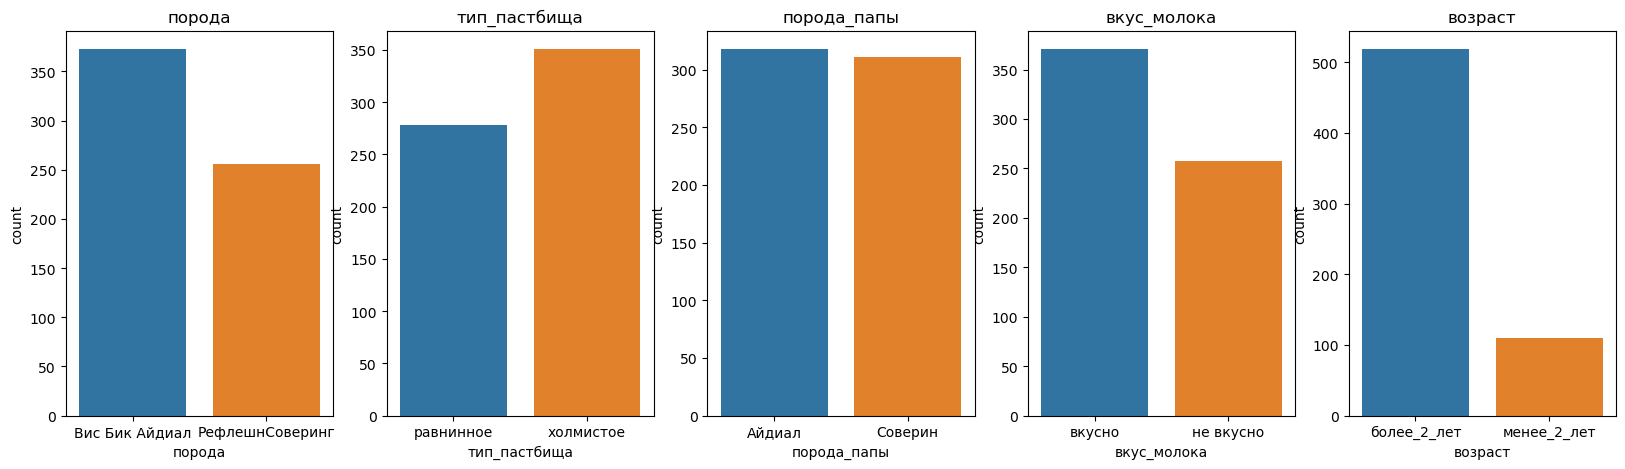

In [20]:
data_cat = ferma_data[['порода', 'тип_пастбища', 'порода_папы', 'вкус_молока', 'возраст']]

# создаю subplots
fig, axs = plt.subplots(1, len(data_cat.columns), figsize=(20, 5))
    

for i, cat in enumerate(data_cat):
    # строю столбчатые диаграммы
    plot_cat_data(data_cat[cat], cat, axs[i])


Все категориальные признаки бинарные, значит, потребуется сделать модель для бинарной классификации, чтобы предсказать вкус молока.

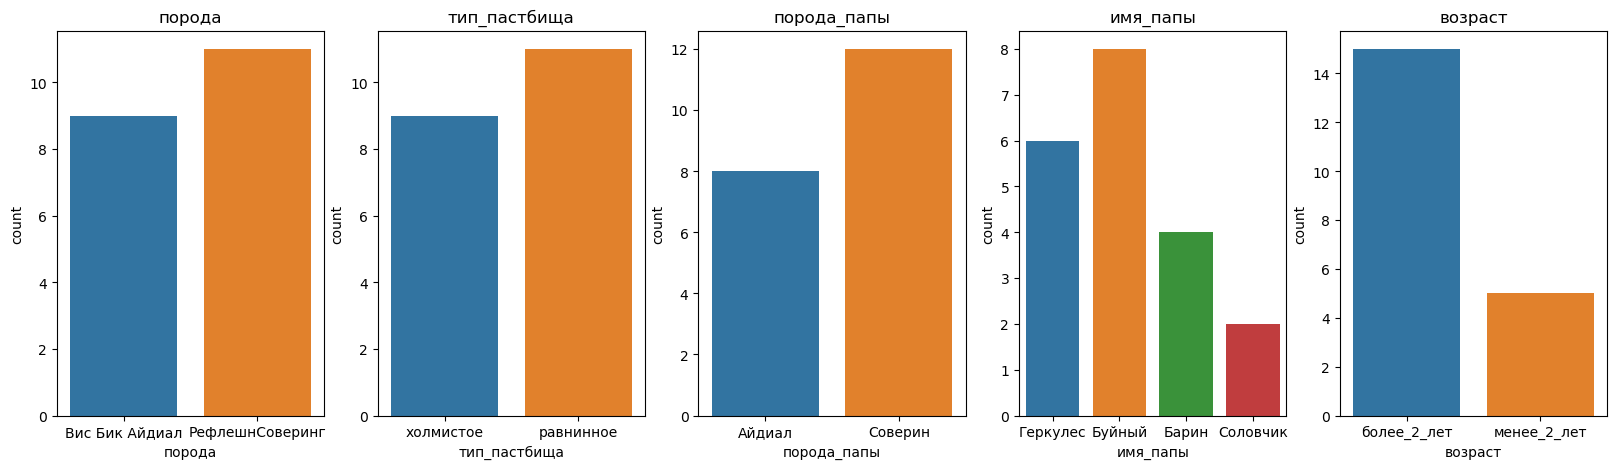

In [21]:
# на всякий случай ещё проверю распределения в датафрейме с коровами к покупке
# может быть упустила какие-нибудь ошибки

data_cat_2 = cow_data[['порода', 'тип_пастбища', 'порода_папы', 'имя_папы', 'возраст']]

# создаю subplots
fig_2, axs_2 = plt.subplots(1, len(data_cat_2.columns), figsize=(20, 5))

for i, cat in enumerate(data_cat_2):
    # строю столбчатые диаграммы
    plot_cat_data(data_cat_2[cat], cat, axs_2[i])
    


### Распределение количественных признаков

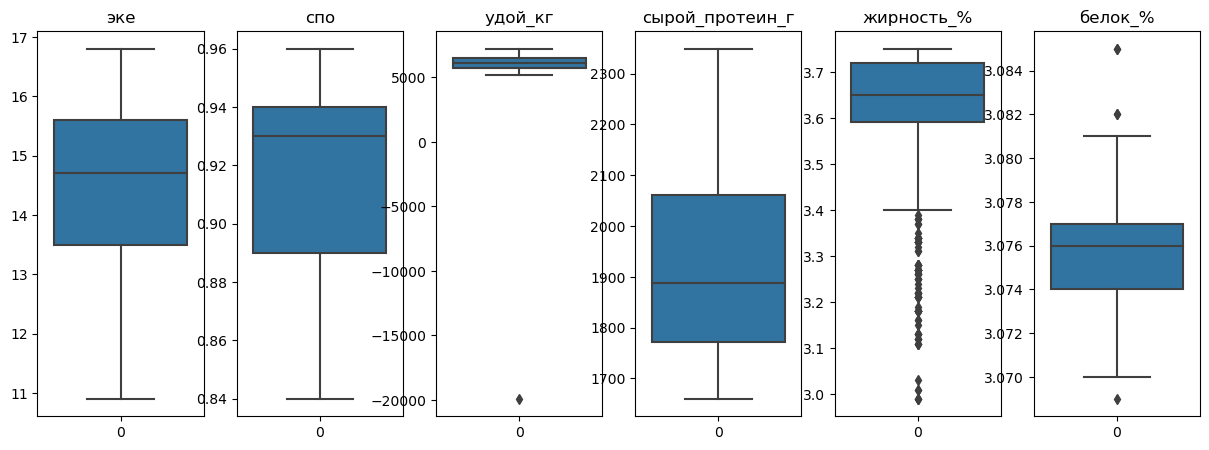

In [22]:
# выведу распределения по каждому показателю в ferma_maim, чтобы детальнее на них посмотреть

data_num = ferma_data[['эке', 'спо', 'удой_кг', 'сырой_протеин_г', 'жирность_%', 'белок_%']]

fig, axs = plt.subplots(1, len(data_num.columns), figsize=(15, 5))


for i, num in enumerate(data_num):
    # построение гистограммы
    plot_num_data(data=data_num[num], title=num, ax=axs[i])

В объёме удоя есть странный выброс. Нужно его изучить и обработать.

In [23]:
ferma_data_cropped = ferma_data[ferma_data['удой_кг'] <= 0]

ferma_data_cropped

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы,жирность_%,белок_%,вкус_молока,возраст
16,17,-19920,11.5,1675,0.93,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


In [24]:
# удалю выброс ещё и из таблицы с данными по папам коров

dad_data = dad_data.drop(dad_data[dad_data['id'] == 17].index).reset_index(drop=True) 
dad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        628 non-null    int64 
 1   имя_папы  628 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.9+ KB


In [25]:
ferma_data_actual = ferma_data.query('удой_кг > 0').reset_index(drop=True) 

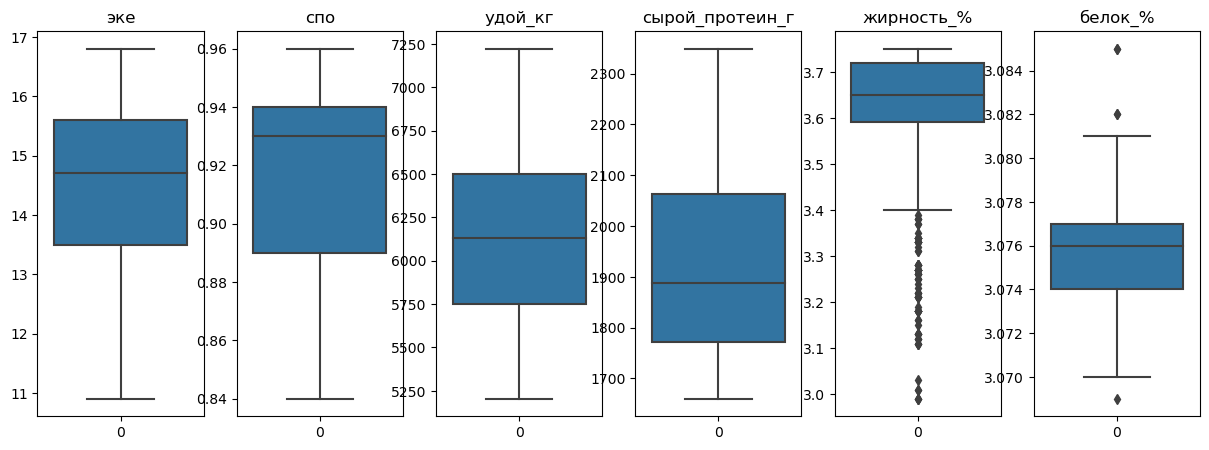

In [26]:
data_num = ferma_data_actual[['эке', 'спо', 'удой_кг', 'сырой_протеин_г', 'жирность_%', 'белок_%']]

fig, axs = plt.subplots(1, len(data_num.columns), figsize=(15, 5))

for i, num in enumerate(data_num):
    # построение гистограммы
    plot_num_data(data=data_num[num], title=num, ax=axs[i])

В датафрейме, на котором будут обучаться модели, количественные признаки разных размеров. Их нужно будет привести к одному масштабу. 

Есть много выбросов в жирности, но не думаю, что с этим нужно что-то делать.

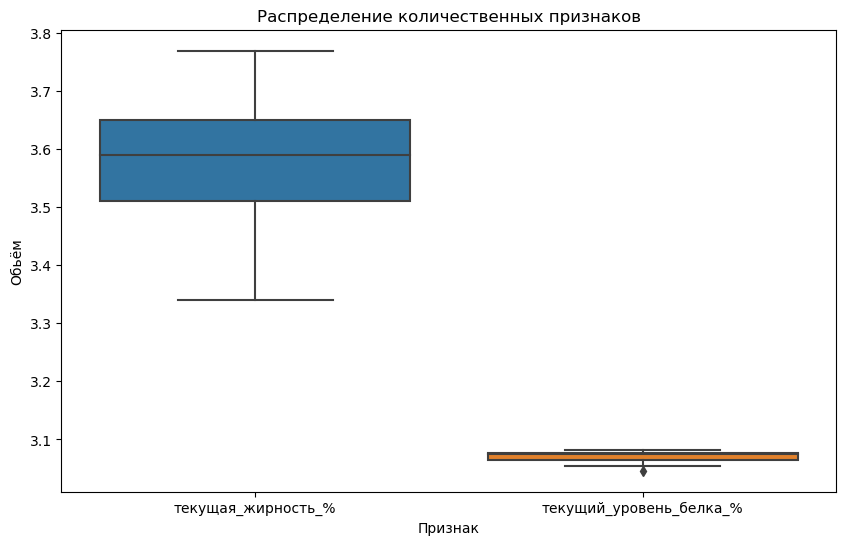

In [27]:
# вывожу распределение количественных признаков в cow_buy

plt.figure(figsize=(10,6))
sns.boxplot(data=cow_data)
plt.title('Распределение количественных признаков')
plt.xlabel('Признак')
plt.ylabel('Обьём')
plt.show()

В детефрейме с коровами к покупке нет части показателей, которые есть в датафрейме для обучения. Скорее всего, что-то нужно будет добавить.

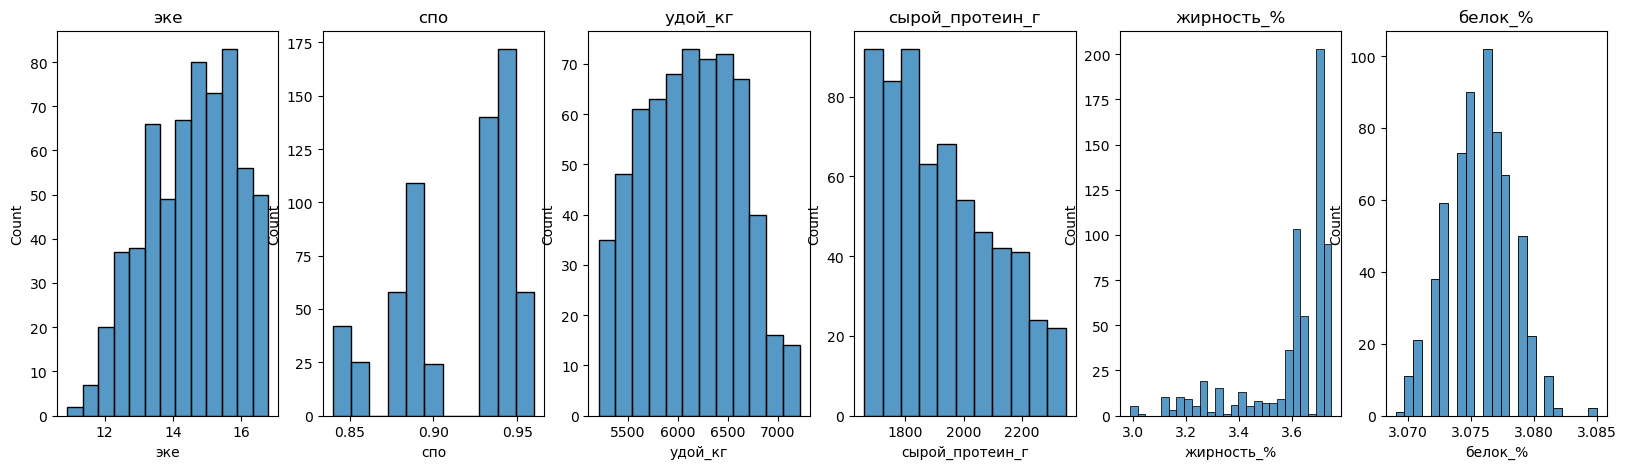

In [28]:
# отдельно посмотрю на гистограммы по каждому показателю в ferma_maim

fig, axs = plt.subplots(1, len(data_num.columns), figsize=(20, 5))

for i, num in enumerate(data_num):
    # построение гистограммы
    hist_num_data(data_num[num], num, axs[i])

- Была 1 аномалия в данных с удоем. Удалила строчку с ошибочным значением. 
- В данных разные диапазоны значений. Перед тем как обучать модуль на признаках, эти признаки надо с помощью масштабирования привести к одному диапазону. 
- Показатель СПО мультимодален, у него видно три пика на графике. Это может в дальнейшем повлиять на результаты модели. Можно попробовать сделать из спо категориальную переменную.
- У показателя жирности молока много выбросов ниже 25-го квартиля, но не думаю, что это надо как-то править, потому что выбросы здесь важны.

Не все признаки распределены нормально, значит, для корреляционного анализа используем коэффициент Спирмана, а не Пирсона.


## Корреляционный анализ признаков

In [29]:
# провожу корреляционный анализ коэффициентом Спирмана


def corr_spearman(data):
    columns = data.columns
    for i in range(0, len(columns)):
        for j in range(i+1, len(columns)):
            coef = data[columns[i]].corr(data[columns[j]], method='spearman')
            print(f'Коэффициент Спирмана между {columns[i]} и {columns[j]}: {coef:.2f}')

corr_spearman(data_num)

Коэффициент Спирмана между эке и спо: 0.74
Коэффициент Спирмана между эке и удой_кг: 0.77
Коэффициент Спирмана между эке и сырой_протеин_г: 0.38
Коэффициент Спирмана между эке и жирность_%: 0.69
Коэффициент Спирмана между эке и белок_%: -0.01
Коэффициент Спирмана между спо и удой_кг: 0.79
Коэффициент Спирмана между спо и сырой_протеин_г: 0.49
Коэффициент Спирмана между спо и жирность_%: 0.70
Коэффициент Спирмана между спо и белок_%: 0.11
Коэффициент Спирмана между удой_кг и сырой_протеин_г: 0.44
Коэффициент Спирмана между удой_кг и жирность_%: 0.69
Коэффициент Спирмана между удой_кг и белок_%: -0.01
Коэффициент Спирмана между сырой_протеин_г и жирность_%: 0.39
Коэффициент Спирмана между сырой_протеин_г и белок_%: 0.23
Коэффициент Спирмана между жирность_% и белок_%: 0.04


Слишком сильных зависимостей нет, но тут пока сравниваются только количественные признаки. Надо изучить ещё корреляцию между количественными и категориальными.

In [30]:
phik_matrix = ferma_data_actual.phik_matrix() 

phik_matrix

interval columns not set, guessing: ['id', 'удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'жирность_%', 'белок_%']


,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы,жирность_%,белок_%,вкус_молока,возраст
id,1.000000,0.000000,0.000000,0.108271,0.382303,0.611843,0.037776,0.320977,0.526684,0.000000,0.039659,0.000000
удой_кг,0.000000,1.000000,0.719239,0.465118,0.661615,0.161643,0.279645,0.518114,0.707322,0.154919,0.178281,0.998071
эке,0.000000,0.719239,1.000000,0.458283,0.591190,0.123086,0.106758,0.171355,0.717365,0.000000,0.272265,0.771596
сырой_протеин_г,0.108271,0.465118,0.458283,1.000000,0.386550,0.090971,0.097165,0.000000,0.400031,0.202598,0.173817,0.353829
спо,0.382303,0.661615,0.591190,0.386550,1.000000,0.062660,0.155349,0.425601,0.647598,0.000000,0.572702,0.744410
порода,0.611843,0.161643,0.123086,0.090971,0.062660,1.000000,0.213218,0.089330,0.230523,0.370629,0.000000,0.057295
тип_пастбища,0.037776,0.279645,0.106758,0.097165,0.155349,0.213218,1.000000,0.000000,0.000000,0.116261,0.269063,0.128455
порода_папы,0.320977,0.518114,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.132675,0.000000,0.355817
жирность_%,0.526684,0.707322,0.717365,0.400031,0.647598,0.230523,0.000000,0.000000,1.000000,0.053689,0.193880,0.677276
белок_%,0.000000,0.154919,0.000000,0.202598,0.000000,0.370629,0.116261,0.132675,0.053689,1.000000,0.124230,0.000000


<Axes: >

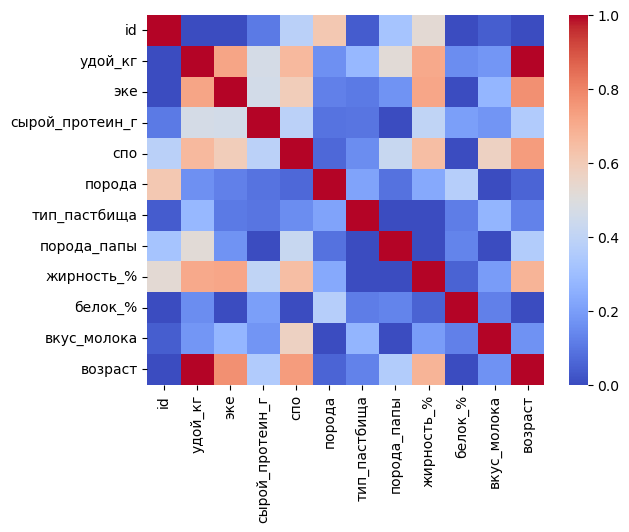

In [31]:
sns.heatmap(phik_matrix, cmap='coolwarm')
plt.show()

Тут пока тоже всё ок, посмотрю ещё на графики рассеяния.

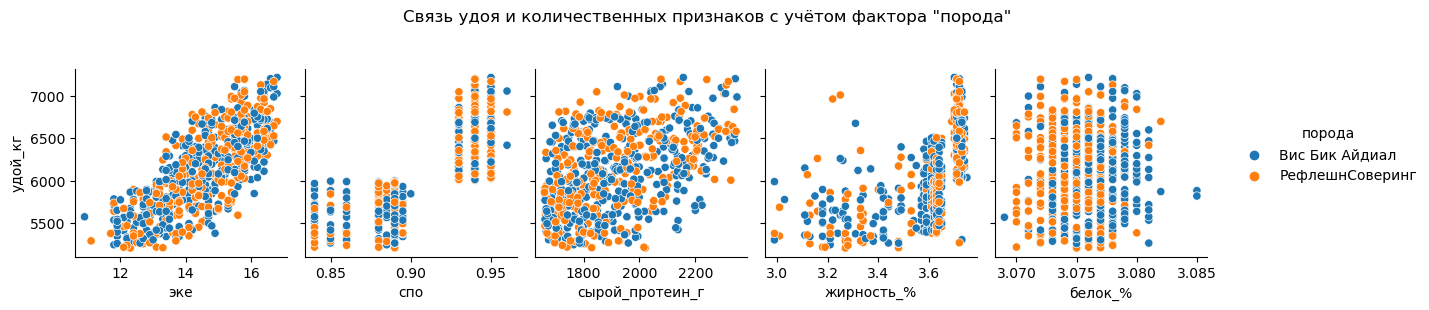

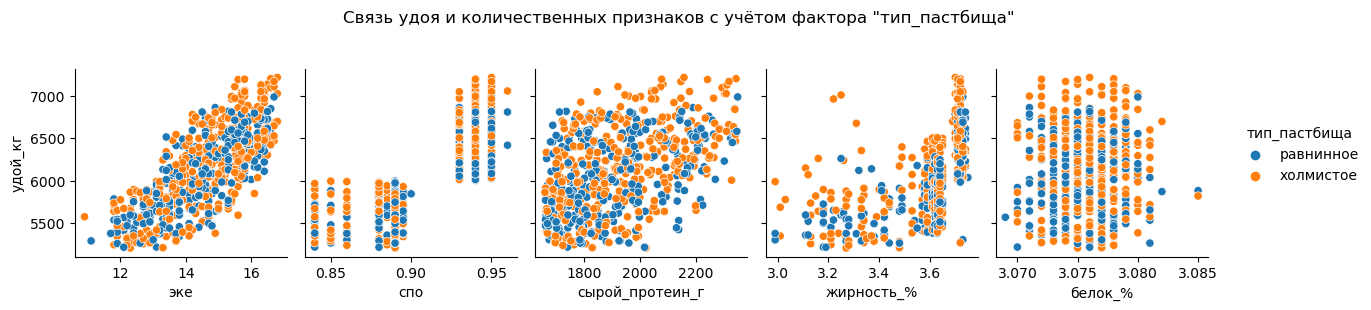

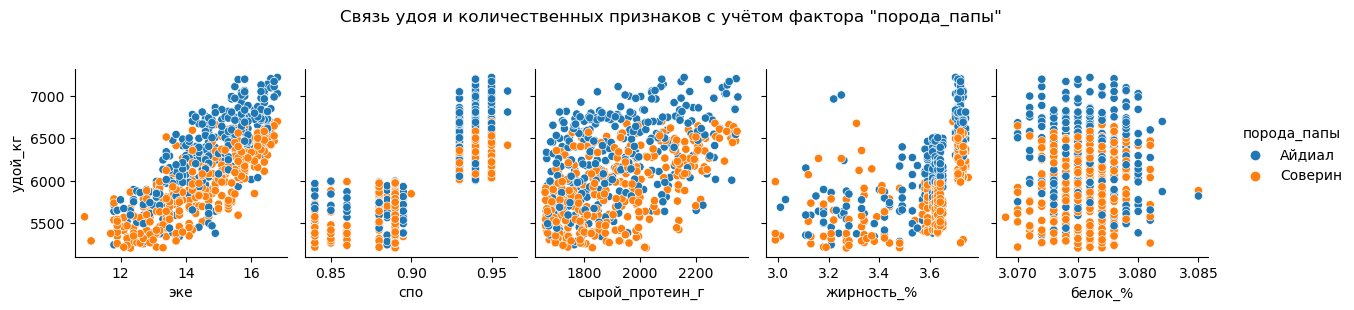

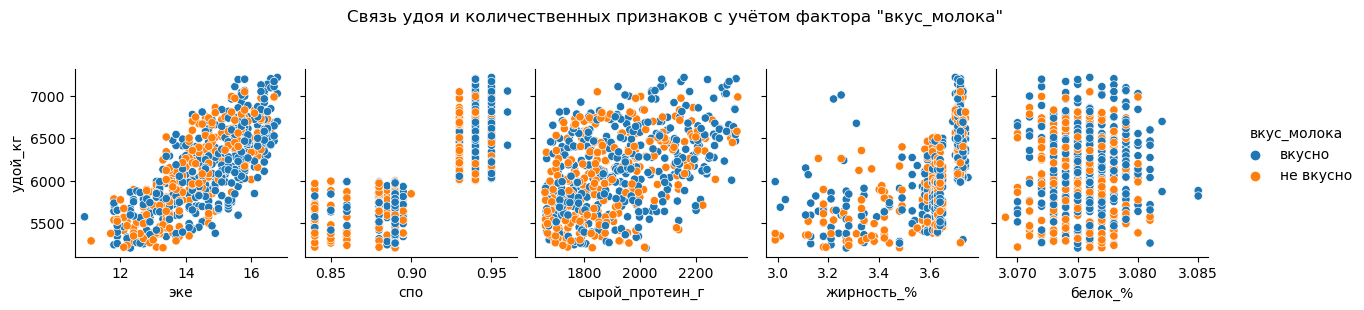

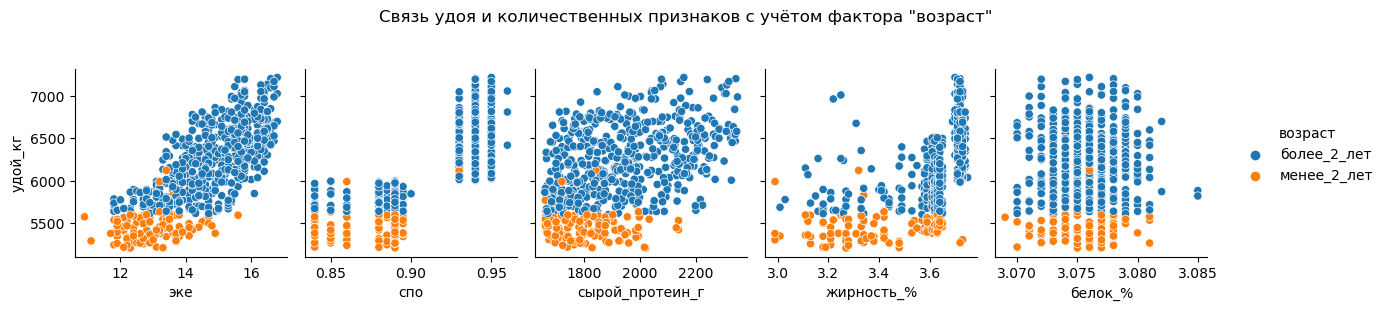

In [32]:
for cat in data_cat.columns:

    sns.pairplot(
        ferma_data_actual,
        x_vars=['эке', 'спо', 'сырой_протеин_г', 'жирность_%', 'белок_%'],
        y_vars=['удой_кг'],
        hue=cat
    )
    plt.suptitle(f'Связь удоя и количественных признаков с учётом фактора "{cat}"', y=1.2)
    plt.show()

Не все входные признаки связаны с целевым признаком линейной связью, хотя у многих из них есть сильная корреляция по Спирману и коэффициенту Фи. Для предсказания количества удоя понадобится настроить линейную связь между показателем удоя и ЭКЕ, а также между удоем и СПО. Для этого нужно добавить столбцы с дополнительными признаками:
- Распределение ЭКЕ похоже на правую часть параболы. Чтобы убрать кривизну, добавлю столбец с показателем ЭКЕ в квадрате.
- СПО сделаю категориальной переменной, а затем закодирую с помощью one-hot encoding.

Мультиколлинеарности между входными признаками не наблюдается, коэффициенты корреляции между ними ниже 0.9. 

## Задача регрессии

### Первая модель

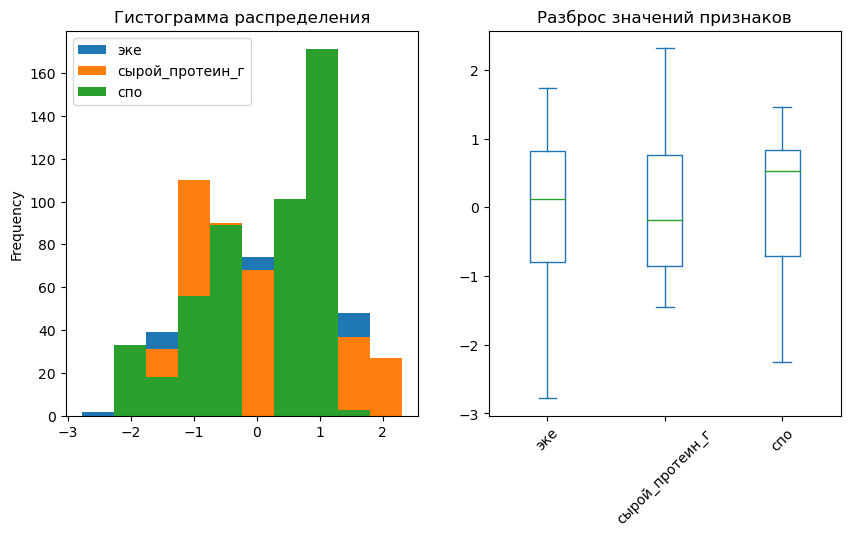

In [33]:
drop_col = ['удой_кг', 'жирность_%', 'белок_%', 'вкус_молока']
cat_col = ['порода','тип_пастбища', 'порода_папы', 'возраст']
num_col = ['эке','сырой_протеин_г', 'спо']

X_train, X_test, y_train, y_test, scaler, encoder = data_for_model(ferma_data_actual, drop_col, cat_col, num_col)


# строю графики по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами, чтобы убедиться, что масштабирование выполнено правильно
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

Данные приведены к нужным форматам, можно приступать к обучению модели.

In [34]:
# инициализирую модель линейной регрессии и обучаю её на тренировочных данных
# получаю предсказания модели на тестовых данных 
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)


# сохраняю результат в переменную predictions
predictions = model_lr.predict(X_test)

# рассчитаю значения R2 для линейной регрессии
r2 = r2 = r2_score(y_test, predictions)  

# вывожу полученное значение R2
print("R2 LinearRegression =", r2)

R2 LinearRegression = 0.78440784055887


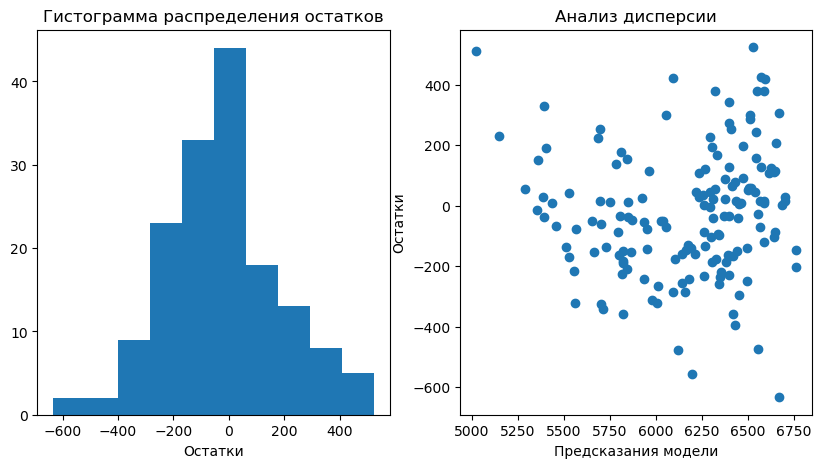

In [35]:
# рассчитаю остатки
residuals = y_test - predictions

# построю графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

1. Коэффициент детерминации R² равен 0.78. Это значит, что модель ошибается в 22%. Не очень хороший показатель, стоит улучшить.
2. По распределению на гистограмме сумма остатков близка к нулю, но дисперсия показывает, что чем выше предсказанное значение удоя, тем больше разброс остатков. Чтобы это исправить, надо добавить в модель дополнительные признаки. В частности в исследовательском анализе уже было видно нелинейную связь между целевым признаком, эке и спо. Исправим эту связь на линейную.

### Вторая модель

In [36]:
## обучаю вторую модель


data_2 = ferma_data_actual.copy()

# делаю из спо категориальный признак и добавляю новый столбец в датафрейм
data_2['спо_бинар'] = np.where(data_2['спо'] > 0.91, 1, 0)

# добавляю новый признак 'эке в квадрате'
data_2['эке_2'] = data_2['эке']**2

drop_col_2 = ['удой_кг', 'жирность_%', 'белок_%', 'вкус_молока', 'эке', 'спо']
cat_col_2 = ['порода','тип_пастбища', 'порода_папы', 'возраст', 'спо_бинар']
num_col_2 = ['сырой_протеин_г', 'эке_2']

X_train_2, X_test_2, y_train_2, y_test_2, scaler_2, encoder_2 = data_for_model(data_2, drop_col_2, cat_col_2, num_col_2)

# инициализирую модель линейной регрессии и обучаю её на тренировочных данных
# получаю предсказания модели на тестовых данных 
model_lr2 = LinearRegression()
model_lr2.fit(X_train_2, y_train_2)


# сохраняю результат в переменную predictions
predictions_2 = model_lr2.predict(X_test_2)

# рассчитаю значения R2 для линейной регрессии
r2_2 = r2_score(y_test_2, predictions_2)  

# вывожу полученное значение R2
print("R2 LinearRegression =", r2_2)


R2 LinearRegression = 0.8180879807099116


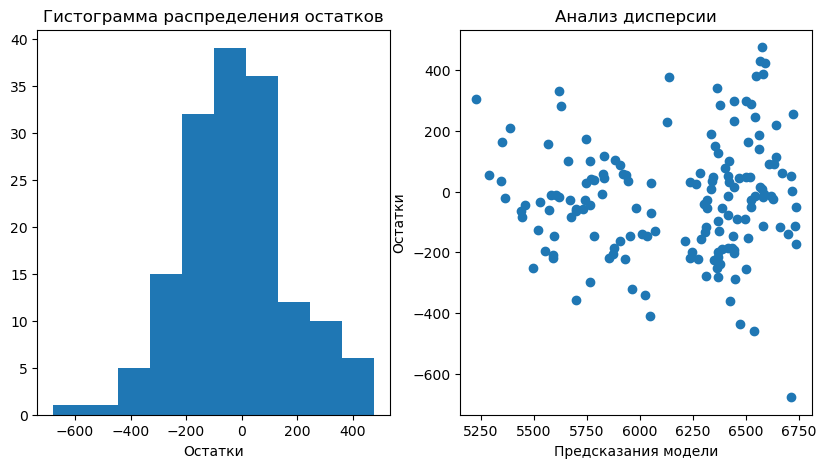

In [37]:
# рассчитаю остатки
residuals_2 = y_test_2 - predictions_2

# построю графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_2)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_2, residuals_2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

1. Коэффициент детерминации R² стал равен 0.82. Это значит, что модель ошибается меньше, в 18%. Можно попробовать ещё улучгить модель.
2. По распределению на гистограмме видно, что распределение стало более нормальным, а дисперсия остатков немного снизилась. 

### Третья модель

In [38]:
## обучаю третью модель


data = ferma_data_actual.copy()

# объединю значения основного датафрейма и датафрейма с именами папы коровы
data_3 = data.merge(dad_data, on='id')

# делаю из спо категориальный признак и добавляю новый столбец в датафрейм
data_3['спо_бинар'] = np.where(data_3['спо'] > 0.91, 1, 0)

# добавляю новый признак 'эке в квадрате'
data_3['эке_2'] = data_3['эке']**2

In [39]:
drop_col_3 = ['удой_кг', 'жирность_%', 'белок_%', 'вкус_молока', 'эке', 'спо']
cat_col_3 = ['порода','тип_пастбища', 'порода_папы', 'возраст', 'спо_бинар', 'имя_папы']
num_col_3 = ['сырой_протеин_г', 'эке_2']

X_train_3, X_test_3, y_train_3, y_test_3, scaler_3, encoder_3 = data_for_model(data_3, drop_col_3, cat_col_3, num_col_3)

# инициализирую модель линейной регрессии и обучаю её на тренировочных данных
# получаю предсказания модели на тестовых данных 
model_lr3 = LinearRegression()
model_lr3.fit(X_train_3, y_train_3)


# сохраняю результат в переменную predictions
predictions_3 = model_lr3.predict(X_test_3)

# рассчитаю значения R2 для линейной регрессии
r2_3 = r2_score(y_test_3, predictions_3)  

# выведите полученное значение R2
print("R2 LinearRegression =", r2_3)


R2 LinearRegression = 0.8247542613822156


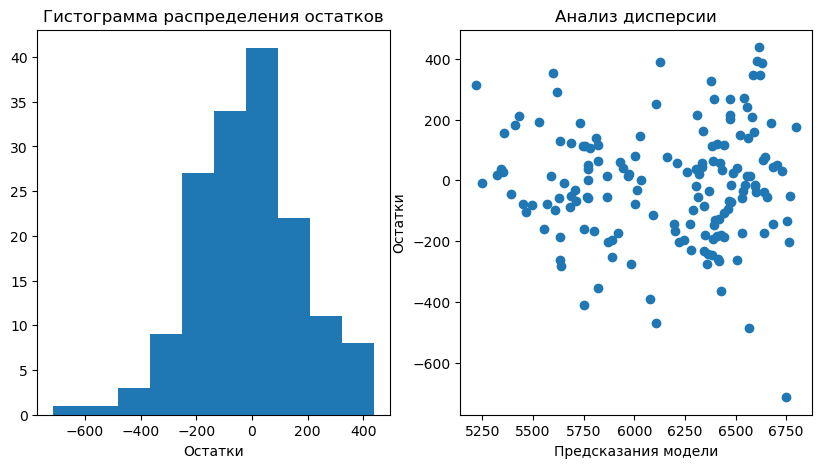

In [40]:
# рассчитаю остатки
residuals_3 = y_test_3 - predictions_3

# построю графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_3)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_3, residuals_3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Третья модель показывает самый лучший коэффициент детерминации R². Распределение на гистограмме и дисперсия остатков не очень изменились. Изучу ещё другие метрики моделей.

### Оценка качества моделей: MSE, MAE, RMSE

In [41]:
first_model_metrics = metrics_linear(y_test, predictions)
second_model_metrics = metrics_linear(y_test_2, predictions_2)
third_model_metrics = metrics_linear(y_test_3, predictions_3)
print(first_model_metrics)
print(second_model_metrics)
print(third_model_metrics)

(164.24192812228532, 43887.01028345745, 209.49226783692387)
(149.0396557333102, 37030.913749201674, 192.43418030381628)
(146.1630279039889, 35673.89256078639, 188.87533603090264)


У третьей модели наилучшие показатели: по mae в среднем модель отклоняется от истинного значения целевого признака примерно на 146 кг, по mse - квадрат отклонения примерно 35674 кг^2, а по rmse - 188 кг. 

In [42]:
# рассчитаю доверительный интервал лучшей модели

np.quantile(predictions_3, 0.025) , np.quantile(predictions_3, 0.975)

(5351.318253504525, 6749.077770542182)

В 95% случаев лучшая модель предскажет значения удоя в диапазоне от 5351 до 6749 кг. В общем, беру третью модель для расчёта удоя коров.

### Прогноз удоя коров, которых фермер хочет купить

In [43]:
cow_data['эке'] = ferma_data_actual['эке'].mean()*1.05
cow_data['сырой_протеин_г'] = ferma_data_actual['сырой_протеин_г'].mean()*1.05
cow_data['спо'] = ferma_data_actual['спо'].mean()*1.05

cow_data['эке_2'] = cow_data['эке']**2
cow_data['спо_бинар'] = np.where(cow_data['спо'] > 0.91, 1, 0)
cow_data['удой_кг'] = None

cow_data['id'] = range(1, len(cow_data) + 1)
cow_data = cow_data.reindex(['id', 'удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'порода', 'тип_пастбища', 'порода_папы', 'текущая_жирность_%', 'текущий_уровень_белка_%', 'возраст', 'имя_папы', 'спо_бинар', 'эке_2'], axis=1)


cow_data.head()

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст,имя_папы,спо_бинар,эке_2
0,1,None,15.276163,2019.947532,0.958744,Вис Бик Айдиал,холмистое,Айдиал,3.58,3.076,более_2_лет,Геркулес,1,233.361168
1,2,None,15.276163,2019.947532,0.958744,Вис Бик Айдиал,равнинное,Соверин,3.54,3.081,менее_2_лет,Буйный,1,233.361168
2,3,None,15.276163,2019.947532,0.958744,РефлешнСоверинг,равнинное,Соверин,3.59,3.074,более_2_лет,Барин,1,233.361168
3,4,None,15.276163,2019.947532,0.958744,РефлешнСоверинг,холмистое,Айдиал,3.40,3.061,более_2_лет,Буйный,1,233.361168
4,5,None,15.276163,2019.947532,0.958744,РефлешнСоверинг,равнинное,Айдиал,3.64,3.074,более_2_лет,Буйный,1,233.361168


In [44]:
# отделяю целевой признак от входных
# не включаю во входные признаки жирность и содержание белка, потому что эти показатели не влияют на объём удоя
# также убрала значения эке и спо, вместо них будут новые добавленные признаки

X_cow = cow_data.drop(['удой_кг', 'текущая_жирность_%', 'текущий_уровень_белка_%', 'спо', 'эке'],  axis=1)
y_cow = cow_data['удой_кг']

# список категориальных признаков
cat_col_names_cow = ['порода','тип_пастбища', 'порода_папы', 'возраст', 'спо_бинар', 'имя_папы']

# преобразование категориальных признаков

X_ohe_cow = encoder_3.transform(X_cow[cat_col_names_cow])

# сохраняю в переменной список названий новых столбцов 
encoder_col_names_cow = encoder_3.get_feature_names_out()

# список количественных признаков 
num_col_names_cow = ['сырой_протеин_г', 'эке_2']


# трансформирование количественных признаков 
X_scaled_cow = scaler_3.transform(X_cow[num_col_names_cow])

# создаю новые датафреймы

X_scaled_cow = pd.DataFrame(X_scaled_cow, columns=num_col_names_cow)
X_ohe_cow = pd.DataFrame(X_ohe_cow, columns=encoder_col_names_cow)


# объединяю все преобразованные данные
# сбрасываю индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
X_cow_result = pd.concat([X_ohe_cow, X_scaled_cow], axis=1)


predictions_cow = model_lr3.predict(X_cow_result)
predictions_cow

array([6609.91942536, 6378.71115039, 6283.99989607, 6593.08951384,
       6542.14619714, 6425.38032698, 6609.91942536, 6571.259855  ,
       6283.99989607, 6400.54080924, 6344.70798939, 6617.92903159,
       6609.91942536, 6127.47487564, 6283.99989607, 6593.08951384,
       6344.70798939, 6425.38032698, 6571.259855  , 6542.14619714])

Модель даёт очень положительные результаты - она предсказывает, что все коровы от "Экофермы" будут давать больше 6000 кг молока в год. Но есть ещё второй показатель, по которому нужно отобрать коров, - вкус молока. Возможно, это снизит количество коров, пригодных к покупке.

## Задача классификации

In [45]:
data_4 = ferma_data_actual.copy()

# объединю значения основного датафрейма и датафрейма с именами папы коровы
data_class = data_4.merge(dad_data, on='id')

# делаю из спо категориальный признак и добавляю новый столбец в датафрейм
data_class['спо_бинар'] = np.where(data_class['спо'] > 0.91, 1, 0)

# добавляю новый признак 'эке в квадрате'
data_class['эке_2'] = data_class['эке']**2

# кодирую бинарный целевой признак
data_class['вкус_молока'] = data_class['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

data_class.head()

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы,жирность_%,белок_%,вкус_молока,возраст,имя_папы,спо_бинар,эке_2
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,Буйный,0,201.639999
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет,Соловчик,0,163.840012
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,более_2_лет,Барин,0,196.000000
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,более_2_лет,Буйный,0,153.759995
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,менее_2_лет,Барин,0,163.840012


In [46]:
## обучаю модель логистической регрессии

drop_col_class = ['вкус_молока', 'удой_кг', 'спо', 'эке']
cat_col_class = ['порода','тип_пастбища', 'порода_папы', 'возраст', 'спо_бинар', 'имя_папы']
num_col_class = ['сырой_протеин_г', 'эке_2', 'жирность_%', 'белок_%']

X_train_class, X_test_class, y_train_class, y_test_class, scaler_class, encoder_class = data_for_model(data_class, drop_col_class, cat_col_class, num_col_class)

# создаю объект для работы с моделью
clf = LogisticRegression(random_state = 42)

# обучаю модель на данных
clf = clf.fit(X_train_class, y_train_class)

# получаю прогнозные метки классов
y_pred = clf.predict(X_test_class)

# провожу оценку точности

log_metrics = metrics_logistic(y_test_class, y_pred)

log_metrics


(0.6305732484076433, 0.8636363636363636, 0.6229508196721312)

Accuracy модели равна 0.63 - в целом она ошибается в 37 случаях. Полнота модели получше - 86% процентов, а precision тоже плоха - всего 62%. Модель нужно будет улучшать.

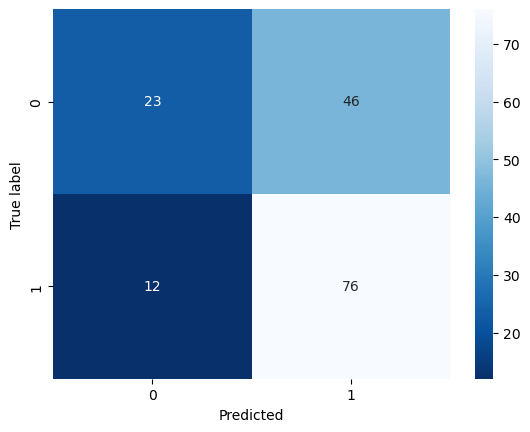

In [47]:
# строю матрицу ошибок

cm = confusion_matrix(y_test_class, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

На матрице ошибок видно, что модель совершила в предсказаниях 46 ошибок первого рода и 12 ошибок второго рода. Поскольку фермеру важнее, чтобы модель не называла невкусное молоко вкусным, то надо увеличить метрику precision. Так модель будет меньше давать ложно-положительных ответов. 

По условию задачи false positive результаты должны быть равны нулю. Найдём максимальный порог классификации, который даёт precision, равной 1. 

In [48]:
# получаю вероятность принадлежности к классу 1
y_proba = clf.predict_proba(X_test_class)[:, 1]


# вычисляю значения precision и recall для различных пороговых значений
precisions, recalls, thresholds = precision_recall_curve(y_test_class, y_proba)

# нахожу порог, при котором precision максимальна
threshold_optimal = thresholds[np.argmax(precisions)]

print("Порог классификации, при котором precision максимальна:", threshold_optimal)


Порог классификации, при котором precision максимальна: 0.8065155045207256


In [49]:

data_class_2 = data_class.copy()

drop_col_class_2 = ['вкус_молока', 'удой_кг', 'спо', 'эке']
cat_col_class_2 = ['порода','тип_пастбища', 'порода_папы', 'возраст', 'спо_бинар', 'имя_папы']
num_col_class_2 = ['сырой_протеин_г', 'эке_2', 'жирность_%', 'белок_%']

X_train_class_2, X_test_class_2, y_train_class_2, y_test_class_2, scaler_class_2, encoder_class_2 = data_for_model(data_class_2, drop_col_class_2, cat_col_class_2, num_col_class_2)

# создаю объект для работы с моделью
clf_2 = LogisticRegression(random_state = 42)

# обучаею модель на данных
clf_2 = clf_2.fit(X_train_class_2, y_train_class_2)

# предсказываю вероятности классов
y_proba_2 = clf_2.predict_proba(X_test_class_2)

# задаю порог классификации
threshold = 0.8

# получаю прогнозные метки классов с новым порогом
y_pred_2 = (y_proba_2[:,1] >= threshold).astype(int)

# провожу оценку точности

log_metrics_2 = metrics_logistic(y_test_class_2, y_pred_2)

log_metrics_2

(0.4840764331210191, 0.09090909090909091, 0.8888888888888888)

Accuracy модели равна снизилась, но зато полнота и precision модели лучше. Теперь модель будет давать меньше ложноположительных ответов.

### Прогноз вкуса молока

In [50]:
cow_data_2 = cow_data.copy()

cow_data_2['вкус_молока'] = None
cow_data_2 = cow_data_2.rename(columns={'текущая_жирность_%': 'жирность_%', 'текущий_уровень_белка_%': 'белок_%'})
cow_data_2 = cow_data_2.reindex(['id', 'удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'порода', 'тип_пастбища', 'порода_папы', 'жирность_%', 'белок_%', 'вкус_молока', 'возраст', 'имя_папы', 'спо_бинар', 'эке_2'], axis=1)


cow_data_2.head()


,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы,жирность_%,белок_%,вкус_молока,возраст,имя_папы,спо_бинар,эке_2
0,1,None,15.276163,2019.947532,0.958744,Вис Бик Айдиал,холмистое,Айдиал,3.58,3.076,None,более_2_лет,Геркулес,1,233.361168
1,2,None,15.276163,2019.947532,0.958744,Вис Бик Айдиал,равнинное,Соверин,3.54,3.081,None,менее_2_лет,Буйный,1,233.361168
2,3,None,15.276163,2019.947532,0.958744,РефлешнСоверинг,равнинное,Соверин,3.59,3.074,None,более_2_лет,Барин,1,233.361168
3,4,None,15.276163,2019.947532,0.958744,РефлешнСоверинг,холмистое,Айдиал,3.40,3.061,None,более_2_лет,Буйный,1,233.361168
4,5,None,15.276163,2019.947532,0.958744,РефлешнСоверинг,равнинное,Айдиал,3.64,3.074,None,более_2_лет,Буйный,1,233.361168


In [51]:
## прогнозирую вкус молока

# создаю константы RANDOM_STATE
RANDOM_STATE = 42

# разбиваю признаки на входные и целевой
X_cow_2 = cow_data_2.drop(['удой_кг', 'вкус_молока', 'спо', 'эке'],  axis=1)
y_cow_2 = cow_data_2['вкус_молока']

# список категориальных признаков
cat_col_names_cow_2 = ['порода','тип_пастбища', 'порода_папы', 'возраст', 'спо_бинар', 'имя_папы']

# преобразование категориальных признаков

X_ohe_cow_2 = encoder_class_2.transform(X_cow_2[cat_col_names_cow_2])

# сохраняю в переменной encoder_col_names список названий новых столбцов 
encoder_col_names_cow_2 = encoder_class_2.get_feature_names_out()

# список количественных признаков
num_col_names_cow_2 = ['сырой_протеин_г', 'эке_2', 'жирность_%', 'белок_%']

# трансформирование количественных признаков из тренировочной выборки 
X_scaled_cow_2 = scaler_class_2.transform(X_cow_2[num_col_names_cow_2])

# создаю новые датафреймы

X_scaled_cow_2 = pd.DataFrame(X_scaled_cow_2, columns=num_col_names_cow_2)
X_ohe_cow_2 = pd.DataFrame(X_ohe_cow_2, columns=encoder_col_names_cow_2)


# объединяю все преобразованные данные
# сбрасываю индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
X_cow_result_2 = pd.concat([X_ohe_cow_2, X_scaled_cow_2], axis=1)

y_proba_cow = clf_2.predict_proba(X_cow_result_2)

# получаем прогнозные метки классов с новым порогом
y_pred_cow = (y_proba_cow[:,1] >= threshold).astype(int)

y_pred_cow

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Поскольку precision настроена на максимальное значение, то в датафрейме просто не оказалось таких значений, которые бы удовлетворяли новому порогу. Чтобы показать фермеру хоть какие-то значения, укажу чуть меньший порог. Но это будет значить, что точность новых предсказаний снизится.

In [52]:
y_proba_cow_final = clf_2.predict_proba(X_cow_result_2)

threshold_2 = 0.7

y_pred_cow_final = (y_proba_cow_final[:,1] >= threshold_2).astype(int)

y_pred_cow_final

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Итоговые выводы

In [53]:
cow_buy_predictions = cow_data_2.copy()


cow_buy_predictions['удой_кг'] = predictions_cow
cow_buy_predictions['вкус_молока'] = y_pred_cow_final
cow_buy_predictions.head()



,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы,жирность_%,белок_%,вкус_молока,возраст,имя_папы,спо_бинар,эке_2
0,1,6609.919425,15.276163,2019.947532,0.958744,Вис Бик Айдиал,холмистое,Айдиал,3.58,3.076,1,более_2_лет,Геркулес,1,233.361168
1,2,6378.711150,15.276163,2019.947532,0.958744,Вис Бик Айдиал,равнинное,Соверин,3.54,3.081,0,менее_2_лет,Буйный,1,233.361168
2,3,6283.999896,15.276163,2019.947532,0.958744,РефлешнСоверинг,равнинное,Соверин,3.59,3.074,0,более_2_лет,Барин,1,233.361168
3,4,6593.089514,15.276163,2019.947532,0.958744,РефлешнСоверинг,холмистое,Айдиал,3.40,3.061,0,более_2_лет,Буйный,1,233.361168
4,5,6542.146197,15.276163,2019.947532,0.958744,РефлешнСоверинг,равнинное,Айдиал,3.64,3.074,0,более_2_лет,Буйный,1,233.361168


In [54]:
best_cows = cow_buy_predictions.query('удой_кг > 6000 and вкус_молока == 1')
best_cows

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы,жирность_%,белок_%,вкус_молока,возраст,имя_папы,спо_бинар,эке_2
0,1,6609.919425,15.276163,2019.947532,0.958744,Вис Бик Айдиал,холмистое,Айдиал,3.58,3.076,1,более_2_лет,Геркулес,1,233.361168
6,7,6609.919425,15.276163,2019.947532,0.958744,Вис Бик Айдиал,холмистое,Айдиал,3.58,3.076,1,более_2_лет,Геркулес,1,233.361168
9,10,6400.540809,15.276163,2019.947532,0.958744,РефлешнСоверинг,холмистое,Айдиал,3.40,3.079,1,менее_2_лет,Буйный,1,233.361168


### Выводы для фермера

Фермер может приобрести три коровы, но с оговорками:
1. Нужно проверить, что две одинаковых строчки - это действительно две разные коровы, а не дубликат в оригинальных данных.
2. Поскольку порог классификации не такой точный, то и молоко некоторых выбранных коров может в итоге оказаться невкусным. Чтобы снизить потери от приобретённых коров, фермер может поторговаться и приобрести коров по более низкой цене.

### Выводы по моделям

#### Улучшение качества модели

1. Чтобы улучшить качество моделей, сначала надо надо выбрать верные типы моделей. Для количественных признаков с линейной связью была выбрана линейная регрессия, а для категориального целевого признака — бинарная логистическая. 
2. Между количественными признаками была настроена линейная зависимость — для этого нужно было добавить два новых признака, один количественный признак был преобразован в категориальный. 
3. Данные были масштабированы и закодированы. 
4. Для обучения модели были подобраны такие входные признаки, которые больше всего связаны с целевыми признаками.

Чтобы ещё улучшить качество моделей, можно попробовать добавить ещё какие-нибудь дополнительные признаки: попросить заказчика или Экоферму прислать ещё какие-нибудь данные по коровам. 

#### Важные метрики при анализе рисков или экономических расчётов

Да все метрики важны) Надо только их правильно подбирать для ситуаций и моделей. 

Например, для линейной регрессии можно подобрать следующие метрики:

- $R^2$ показывает, в скольких процентах случаев предсказание модели точнее, чем среднее значение целевого признака.
- MAE показывает, на какое значение предсказание в среднем отличается от истинного значения.

А для логистической такие:

- Accuracy показывает долю правильно классифицированных примеров.
- Precision — точность, с которой модель присваивает объектам класс 1, то есть получает  положительные значения.
- Recall — метрика измеряет, смогла ли модель классификации присвоить класс 1 всем объектам этого класса.